## Step1 因子算法

In [1]:
#coding=utf-8
import pandas as pd
import talib as ta
import numpy as np

# 1. 编制函数需要的算法，调用talib计算momentum
def momentum(df, period=5):
    return pd.DataFrame(
        {name: ta.ROCR(item.values, period)
         for name, item in df.iteritems()},
         index=df.index
        )

def winsorize(df):
    q = df.quantile([0.025, 0.975])
    if isinstance(q, pd.Series) and len(q) == 2:
        df[df < q.iloc[0]] = q.iloc[0]
        df[df > q.iloc[1]] = q.iloc[1]
    return df

def standardize(df):
    df_std = df.std()
    df_mean = df.mean()
    return (df - df_mean) / df_std

# 2. 定义计算alpha值的类
class alphas(object):
    def __init__(self, pn_data):
        self.close = pn_data.minor_xs('close')
        self.PE = pn_data.minor_xs('PE')
        self.PB = pn_data.minor_xs('PB')
        self.PS = pn_data.minor_xs('PS')
        self.PCF = pn_data.minor_xs('PCF')

# 3. 编制因子的函数，并返回因子DataFrame
    def mom_alpha(self):
        alpha = -1 * momentum(self.close)
        return alpha

    def PE_alpha(self):
        alpha = -standardize(winsorize(self.PE))
        return alpha

    def PB_alpha(self):
        alpha = -standardize(winsorize(self.PB))
        return alpha

    def PS_alpha(self):
        alpha = -standardize(winsorize(self.PS))
        return alpha

    def PCF_alpha(self):
        alpha = -standardize(winsorize(self.PCF))
        return alpha

## Step2 获取股票池（沪深300 & 创业板）

In [2]:
# 4. 传入股票数据(这里可以换板块与分类)
if __name__ == '__main__':
    from fxdayu_data import DataAPI
    from datetime import datetime
    import tushare as ts
    import numpy as np
    # from sklearn import preprocessing
    import matplotlib.pyplot as plt
    import pandas as pd
    import alphalens

/Users/calvinku/anaconda/envs/fxdayu/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Step3 获取数据并计算IC

In [3]:
    start = datetime(2013, 1, 1)
    hs300_PN = DataAPI.factor("HS300", ('PE', 'PB', 'PS', 'PCF'), start=start)
    hs300_price = DataAPI.candle("HS300", "D", "close", start=start)
    hs300_PN.loc[:, :, 'close'] = hs300_price.loc[:, :, 'close']
    hs300_PN

<class 'pandas.core.panel.Panel'>
Dimensions: 300 (items) x 1077 (major_axis) x 5 (minor_axis)
Items axis: 000001.XSHE to 603993.XSHG
Major_axis axis: 2013-01-04 15:00:00 to 2017-06-13 15:00:00
Minor_axis axis: PB to close

In [4]:
    import alphalens

    #5. 输出Factor数
    alpha = alphas(hs300_PN)
    hs300_prices = hs300_PN.minor_xs("close")

    hs300_factors = {'mom': alpha.mom_alpha(),
               'pe': alpha.PE_alpha(),
               'pb': alpha.PB_alpha(),
               'ps': alpha.PS_alpha(),
               'pcf': alpha.PCF_alpha()}

    def cal_monthly_ic(factor):
        hs300_factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor.stack(), hs300_prices, quantiles=5)
        return alphalens.performance.mean_information_coefficient(hs300_factor_data, by_time='M')

    hs300_monthly_ic = {key: cal_monthly_ic(value) for key, value in hs300_factors.items()}

    hs300_monthly_ic_mean = pd.DataFrame(
        map(lambda frame: frame.mean(), hs300_monthly_ic.values()),
        hs300_monthly_ic.keys()
    )
    hs300_monthly_ic_std = pd.DataFrame(
        map(lambda frame: frame.std(), hs300_monthly_ic.values()),
        hs300_monthly_ic.keys()
    )
    print hs300_monthly_ic_std

           1         5         10
pb   0.040647  0.085181  0.112603
ps   0.045721  0.093583  0.123749
pcf  0.016006  0.035434  0.048548
mom  0.047900  0.065363  0.063026
pe   0.031437  0.068369  0.089365


## Step4 用柱图显示IC的均值与标准差

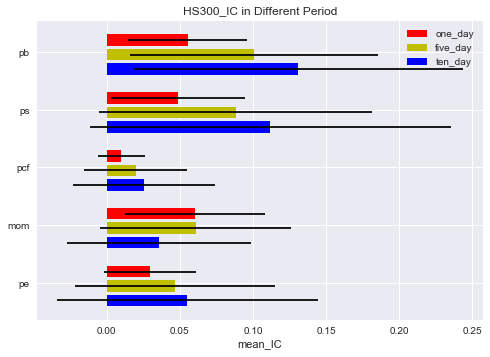

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

N=5
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

# Example data
ind_name = tuple(hs300_monthly_ic_mean.index)
y_pos = np.arange(len(ind))

one_mean = hs300_monthly_ic_mean.iloc[:,0]
one_std = hs300_monthly_ic_std.iloc[:,0]
five_mean = hs300_monthly_ic_mean.iloc[:,1]
five_std = hs300_monthly_ic_std.iloc[:,1]
ten_mean = hs300_monthly_ic_mean.iloc[:,2]
ten_std = hs300_monthly_ic_std.iloc[:,2]


ax.barh(ind - width, one_mean, align='edge',height=0.2, xerr=one_std, label='one_day', color='r')
ax.barh(ind - 0.05, five_mean, align='edge',height=0.2,xerr=five_std, label='five_day', color='y')
ax.barh(ind + width, ten_mean, align='center',height=0.2,xerr=ten_std, label='ten_day', color='b')

ax.set_yticks(y_pos)
ax.set_yticklabels(ind_name)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('mean_IC')
ax.set_title('HS300_IC in Different Period')
plt.legend()
plt.show()

In [7]:
    gem_prices = DataAPI.candle("GEM", 'D', "close", start=start).minor_xs('close')
    

In [8]:
    target = gem_prices.tail(20).dropna(1).columns
    gem_prices = gem_prices[target]
    

In [10]:
    gem_PN = DataAPI.factor(tuple(target), ("PB", "PE", "PS", "PCF"), start=start)
    gem_PN

<class 'pandas.core.panel.Panel'>
Dimensions: 554 (items) x 1077 (major_axis) x 4 (minor_axis)
Items axis: 300001.XSHE to 300650.XSHE
Major_axis axis: 2013-01-04 15:00:00 to 2017-06-13 15:00:00
Minor_axis axis: PB to PS

In [11]:
    gem_PN.loc[:, :, 'close'] = gem_prices

In [12]:
    print gem_prices
    alpha = alphas(gem_PN)

    gem_factors = {'mom': alpha.mom_alpha(),
               'pe': alpha.PE_alpha(),
               'pb': alpha.PB_alpha(),
               'ps': alpha.PS_alpha(),
               'pcf': alpha.PCF_alpha()}

    def cal_monthly_ic(factor):
        gem_factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor.stack(), gem_prices, quantiles=5)
        return alphalens.performance.mean_information_coefficient(gem_factor_data, by_time='M')

    gem_monthly_ic = {key: cal_monthly_ic(value) for key, value in gem_factors.items()}

    gem_monthly_ic_mean = pd.DataFrame(
        map(lambda frame: frame.mean(), gem_monthly_ic.values()),
        gem_monthly_ic.keys()
    )
    gem_monthly_ic_std = pd.DataFrame(
        map(lambda frame: frame.std(), gem_monthly_ic.values()),
        gem_monthly_ic.keys()
    )
    print gem_monthly_ic_std

                     300001.XSHE  300002.XSHE  300003.XSHE  300004.XSHE  \
2013-01-04 15:00:00      11.1100      15.5300       9.1000      17.7600   
2013-01-07 15:00:00      11.0399      15.8200       9.2899      17.7200   
2013-01-08 15:00:00      11.0399      15.8600       9.4800      18.0799   
2013-01-09 15:00:00      10.9900      15.8500       9.3000      17.5600   
2013-01-10 15:00:00      11.0000      15.8800       9.3800      17.6300   
2013-01-11 15:00:00          NaN      16.7600       9.2600      17.9800   
2013-01-14 15:00:00          NaN      17.1000       9.5800      19.0799   
2013-01-15 15:00:00          NaN      17.2700       9.8600      19.9000   
2013-01-16 15:00:00          NaN      17.1000       9.7600      19.9500   
2013-01-17 15:00:00          NaN      16.6900       9.9500      20.2800   
2013-01-18 15:00:00      11.4300      17.0000      10.0600      22.3100   
2013-01-21 15:00:00      11.4100      16.8299      10.1000      24.5400   
2013-01-22 15:00:00      

           1         5         10
pb   0.037756  0.071039  0.091749
ps   0.041740  0.073822  0.093305
pcf  0.017874  0.027288  0.038498
mom  0.048431  0.054877  0.051858
pe   0.032972  0.054528  0.070203


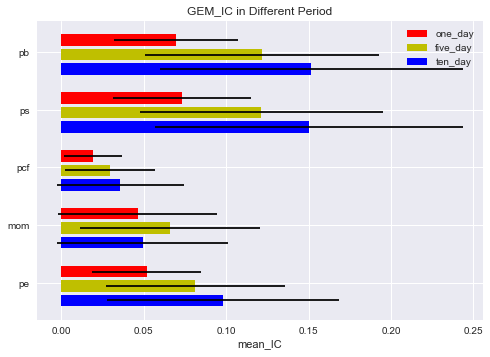

In [13]:
fig, ax = plt.subplots()

N=5
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

# Example data
ind_name = tuple(gem_monthly_ic_mean.index)
y_pos = np.arange(len(ind))

one_mean = gem_monthly_ic_mean.iloc[:,0]
one_std = gem_monthly_ic_std.iloc[:,0]
five_mean = gem_monthly_ic_mean.iloc[:,1]
five_std = gem_monthly_ic_std.iloc[:,1]
ten_mean = gem_monthly_ic_mean.iloc[:,2]
ten_std = gem_monthly_ic_std.iloc[:,2]


ax.barh(ind - width, one_mean, align='edge',height=0.2, xerr=one_std, label='one_day', color='r')
ax.barh(ind - 0.05, five_mean, align='edge',height=0.2,xerr=five_std, label='five_day', color='y')
ax.barh(ind + width, ten_mean, align='center',height=0.2,xerr=ten_std, label='ten_day', color='b')

ax.set_yticks(y_pos)
ax.set_yticklabels(ind_name)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('mean_IC')
ax.set_title('GEM_IC in Different Period')
plt.legend()
plt.show()

## Step5 计算Rolling IC与设置IC=0.02的阈值

In [14]:
    monthly_ic = pd.Panel.from_dict(hs300_monthly_ic)

    from fxdayu_data.tools.pandas_tools import pipeline

    print pipeline(**{str(i): monthly_ic.minor_xs(i) for i in (1, 5, 10)})

                       1        10         5
date                                        
2013-01-31 mom  0.004792  0.027721 -0.031590
           pb   0.050674  0.125434  0.069982
           pcf  0.012548  0.016416  0.016489
           pe   0.009857 -0.010709 -0.021513
           ps   0.030921  0.074557  0.035669
2013-02-28 mom  0.021017  0.012037  0.039149
           pb   0.111893  0.286857  0.256164
           pcf  0.013973  0.045836  0.049181
           pe   0.048711  0.121266  0.114172
           ps   0.077246  0.245357  0.202030
2013-03-31 mom  0.053965  0.049359  0.122459
           pb   0.028784  0.035189  0.013950
           pcf -0.008220 -0.059884 -0.042944
           pe   0.016459 -0.011740 -0.013109
           ps   0.029155  0.017639  0.017626
2013-04-30 mom  0.031172 -0.061003 -0.014021
           pb   0.041555  0.198336  0.096672
           pcf -0.014810 -0.030229 -0.041670
           pe  -0.012154  0.017122 -0.012799
           ps  -0.002715  0.069908 -0.002972
2013-05-31

/Users/tianruiqi/Anaconda/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  """Entry point for launching an IPython kernel.


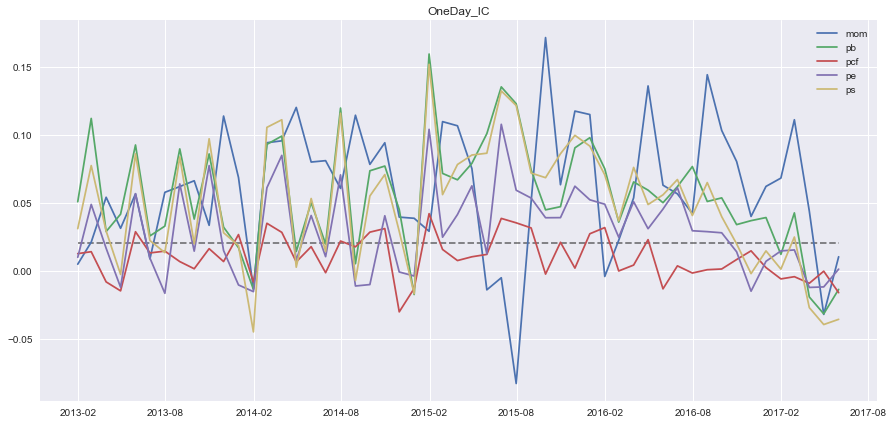

In [15]:
fig = plt.figure(figsize=(15,7))
plt.plot(monthly_ic.minor_xs(1))
plt.hlines(0.02,monthly_ic.minor_xs(1).index[0],monthly_ic.minor_xs(1).index[-1] , linestyles='dashed', alpha=0.5)
plt.legend(monthly_ic.minor_xs(1).columns)
plt.title('OneDay_IC')
plt.show()

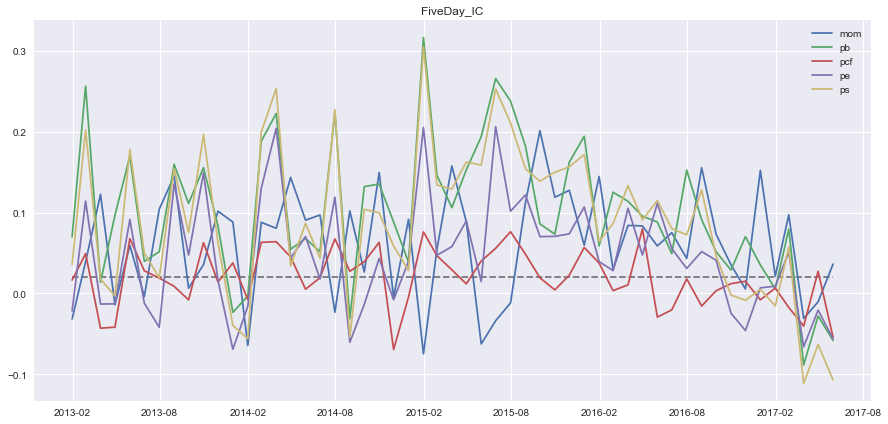

In [38]:
fig = plt.figure(figsize=(15,7))
plt.plot(monthly_ic.minor_xs(5))
plt.hlines(0.02,monthly_ic.minor_xs(5).index[0],monthly_ic.minor_xs(5).index[-1] , linestyles='dashed', alpha=0.5)
plt.legend(monthly_ic.minor_xs(5).columns)
plt.title('FiveDay_IC')
plt.show()

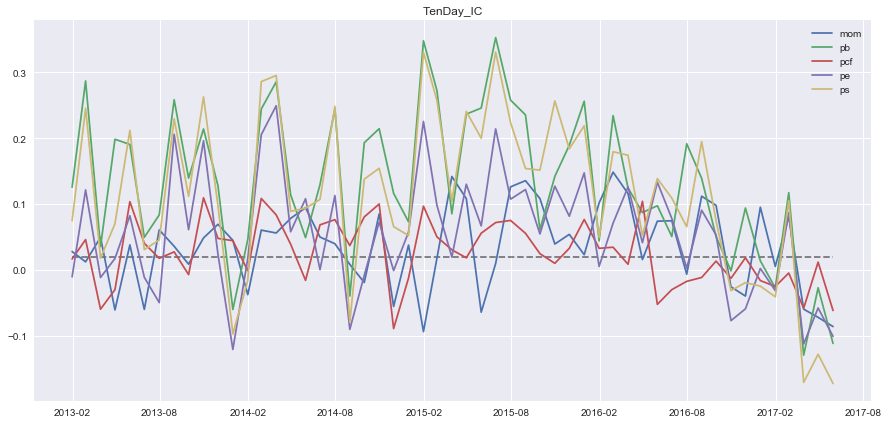

In [16]:
fig = plt.figure(figsize=(15,7))
plt.plot(monthly_ic.minor_xs(10))
plt.hlines(0.02,monthly_ic.minor_xs(10).index[0],monthly_ic.minor_xs(10).index[-1] , linestyles='dashed', alpha=0.5)
plt.legend(monthly_ic.minor_xs(10).columns)
plt.title('TenDay_IC')
plt.show()

## Step6 检验IC是否满足正态分布

In [17]:
from statsmodels.stats.stattools import jarque_bera

print monthly_ic.minor_xs(1)
_, pvalue1, _, _ = jarque_bera(monthly_ic.minor_xs(1).dropna().values)
print 'pvalue One_Day is normally distributed', pvalue1

                 mom        pb       pcf        pe        ps
date                                                        
2013-01-31  0.004792  0.050674  0.012548  0.009857  0.030921
2013-02-28  0.021017  0.111893  0.013973  0.048711  0.077246
2013-03-31  0.053965  0.028784 -0.008220  0.016459  0.029155
2013-04-30  0.031172  0.041555 -0.014810 -0.012154 -0.002715
2013-05-31  0.056466  0.092385  0.028649  0.056623  0.085863
2013-06-30  0.008730  0.025566  0.013055  0.009272  0.022159
2013-07-31  0.057599  0.032768  0.014400 -0.016571  0.013300
2013-08-31  0.061833  0.089496  0.006705  0.063786  0.083625
2013-09-30  0.066097  0.037948  0.001436  0.014382  0.019773
2013-10-31  0.033345  0.085818  0.016181  0.077222  0.096933
2013-11-30  0.113634  0.031998  0.006726  0.014828  0.027910
2013-12-31  0.068501  0.016931  0.026562 -0.010466  0.018414
2014-01-31 -0.013395 -0.013697 -0.008325 -0.015375 -0.044961
2014-02-28  0.094040  0.092838  0.034857  0.060954  0.105320
2014-03-31  0.095446  0.

## Step 7 计算IR

In [18]:
# IR = mean/std

def IR(df):
    return df.mean()/df.std()
print 'OneDay_IR:', IR(monthly_ic.minor_xs(1))
print 'FiveDay_IR:', IR(monthly_ic.minor_xs(5))
print 'TenDay_IR:', IR(monthly_ic.minor_xs(10))

OneDay_IR: mom    1.257591
pb     1.358264
pcf    0.622014
pe     0.937527
ps     1.061499
dtype: float64
FiveDay_IR: mom    0.929679
pb     1.182427
pcf    0.554039
pe     0.685590
ps     0.941119
dtype: float64
TenDay_IR: mom    0.568967
pb     1.163069
pcf    0.526007
pe     0.617016
ps     0.904641
dtype: float64
